In [10]:
import scipy.io
import numpy as np
import utils_dist as helper
from utils_dist import paddedzoom
import matplotlib.pyplot as plt

In [11]:
mat = scipy.io.loadmat('data_brain_8coils.mat')
kdata = mat['d']
sens_maps = mat['c']
noise_maps = mat['n']

In [12]:
kdata.shape, sens_maps.shape, noise_maps.shape

((256, 256, 8), (256, 256, 8), (256, 8))

AttributeError: 'numpy.ndarray' object has no attribute 'imshow'

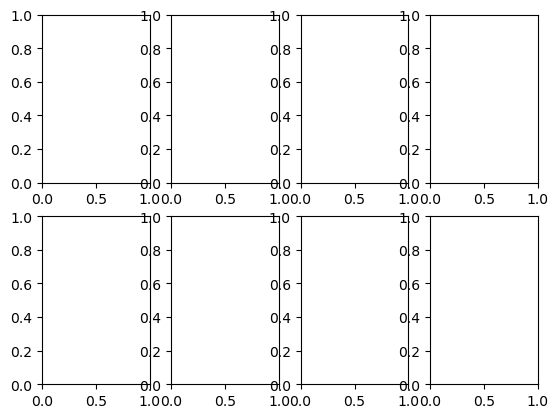

In [13]:
coil_recon = helper.ifft2c(kdata, axes=(0, 1))
coil_recon_t = coil_recon.transpose(2,0,1)
helper.imshow1row(coil_recon_t[:4,:,:])
helper.imshow1row(coil_recon_t[4:,:,:])

AttributeError: 'numpy.ndarray' object has no attribute 'imshow'

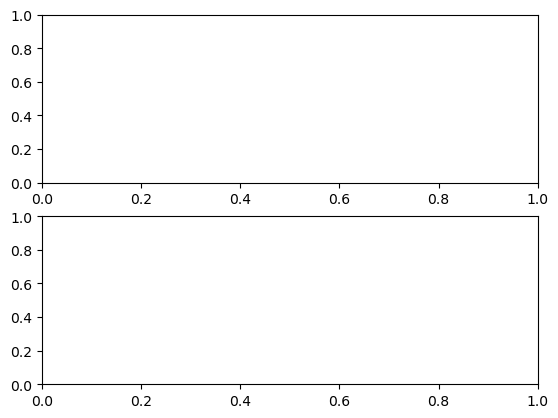

In [8]:
coil_recon_sum = np.sum(coil_recon, axis=2)
helper.imshow1row([coil_recon_sum])

In [9]:
def sos_comb(m):
    '''
    Sum of square

    :param m: multicoil images [nPE, nFE, nCh]

    :return: mc: combined image [nPE, nFE]
    '''

    mean = np.mean(m, axis=2)
    img = []
    for i in range(m.shape[2]):
         s = np.power(np.abs((m[:,:,i]-mean)),2)
         img.append(s)
    mc = sum(img)
    return np.sqrt(mc)

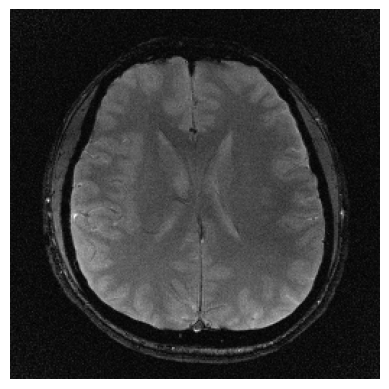

In [94]:
sos = sos_comb(coil_recon)
helper.imshow1row([sos])

In [99]:
from scipy.linalg import fractional_matrix_power, pinv
def ls_comb(m, c, PSI=None):
    '''
    Least-squares (matched filter)

    :param m: multicoil images [nPE,nFE,nCh]
    :param c: coil sensitivity maps [nPE,nFE,nCh]
    :param PSI: noise correlation matrix [nCh, nCh] (optional [None or PSI])

    :return: mc: combined image [nPE,nFE]
    '''

    if PSI is not None:
        psi_is = fractional_matrix_power(PSI, -1 / 2)
        c = (psi_is @ c.transpose(0, 2, 1)).transpose(0, 2, 1)
        m = (psi_is @ m.transpose(0, 2, 1)).transpose(0, 2, 1)
    numerator = np.sum(c.conj() * m, axis=-1)
    denominator = np.linalg.norm(c, axis=-1)
    mc = np.divide(numerator, denominator, where=(denominator!=0))
    return mc

In [100]:
PSI = np.cov(noise_maps.T)
helper.imshow1row([PSI], filename='1_noise')
ls_comb_wo_n = ls_comb(coil_recon, sens_maps)
ls_comb_w_n = ls_comb(coil_recon, sens_maps, PSI)
helper.imshow1row([ coil_recon_sum, sos, ls_comb_wo_n, ls_comb_w_n], ['Complex sum', 'SoS', 'LS w/o PSI','LS w/ PSI'], isMag=True, filename='1_res')
helper.imshow1row([paddedzoom(abs(coil_recon_sum),zoomfactor=3), paddedzoom(abs(sos),zoomfactor=3), paddedzoom(abs(ls_comb_wo_n),zoomfactor=3), paddedzoom(abs(ls_comb_w_n),zoomfactor=3)], ['Complex sum', 'SoS', 'LS w/o PSI','LS w/ PSI'],isMag=True, filename='1_res_zoom')

In [73]:
sens_maps_t = sens_maps.transpose(2,0,1)
helper.imshow1row(sens_maps_t[:4,:,:], filename='1_sense')
helper.imshow1row(sens_maps_t[4:,:,:], filename='2_sense')

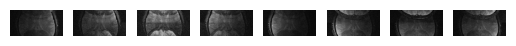

In [74]:
coil_recon_R2 = helper.ifft2c(kdata[::2,:,:],axes=(0,1))
helper.imshow1row([coil_recon[..., 3], coil_recon_R2[..., 3]],  filename='2_aliased')
helper.imshow1row(coil_recon_R2.transpose(2,0,1))

In [75]:
R=[1,2,3,4]
title = []
recon =[]
gmap=[]
for i in range(len(R)):
      ia = helper.ifft2c(kdata[::R[i]],axes=(0,1))
      ir, g = helper.sense_recon(ia, sens_maps, PSI, R[i])
      recon.append(abs(ir))
      gmap.append(g)
      title.append('R=' + str(R[i]))


In [76]:
g_avg = []
for i in range(len(gmap)):
    g = gmap[i]
    g_roi = g[g!=0]
    g_a = np.average(g_roi)
    g_avg.append('g-factor=' + str(round(g_a, ndigits=2)))
    

g_avg

['g-factor=1.0', 'g-factor=1.17', 'g-factor=2.12', 'g-factor=5.73']

In [78]:
helper.imshow1row(recon, title, filename='2_recon')
helper.imshow1row(gmap, g_avg, filename='1_gmap')

In [79]:
import math
from skimage.util import compare_images

def calc_perf(original, titles: list, results: list, rmse: bool = True):

    perf = np.zeros([1,len(results)])
    for i, img in enumerate(results):
        if rmse:
            MSE = np.square(np.subtract(abs(original), abs(img))).mean()
            RMSE = math.sqrt(MSE)

        perf[:, i] = np.array((RMSE))
    res = np.vstack((np.array(titles), perf))
    print(res)
    return res

In [80]:
perf = calc_perf(ls_comb_w_n, title, recon)

[['R=1' 'R=2' 'R=3' 'R=4']
 ['100.99103315184233' '101.69241490837716' '101.95072442219022'
  '101.79687778889361']]


In [81]:
perf = calc_perf(ls_comb_wo_n, title, recon)

[['R=1' 'R=2' 'R=3' 'R=4']
 ['1.2171935482332692' '0.5309063551317926' '0.38846378061483544'
  '0.878306264730778']]


In [104]:
error = helper.diff_images(abs(recon[0]), recon)
helper.imshow1row(error, title,filename='2_error')

In [59]:
def calc_g(C):
    '''
    Calculate g-factor
    @param C: C^H*PSI^(-1)*C
    @return: g-factor
    '''
    g = np.sqrt(np.real(np.diag(pinv(np.conj(C.T) @ C)) * np.diag(np.conj(C.T) @ C)))
    return g

In [60]:
def get_alias_idx(PE, R, locs):
    '''
    Get an index for aliased image among indices in locs
    @param PE: Length of phase encoding
    @param R: Acceleration factor
    @param locs: indices for SENSE reconstruction at one point
    @return: an index for aliased image
    '''
    alias_PE = np.arange(0, PE, R).size
    min_idx = PE // 2 - alias_PE // 2
    max_idx = PE // 2 + alias_PE // 2
    for loc in locs:
        if min_idx <= loc < max_idx:
            return loc - min_idx
    else:
        return None

In [1]:
ls_comb_w_n_norm = (ls_comb_w_n - ls_comb_w_n.min())/(ls_comb_w_n.max() - ls_comb_w_n.min())

NameError: name 'ls_comb_w_n' is not defined